# Link with MAGIK

This notebook shows how to use using [MAGIK](https://www.nature.com/articles/s42256-022-00595-0) (Motion Analysis Through Graph Inductive Knowledge) to link detections (previously provided by LodeSTAR) across time frames to create trajectories.

# Create Data for training

In [ ]:
import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm, trange
# from urllib.request import urlretrieve

# from torch.utils.data import Dataset

We will use the DIC-C2DH-HeLa dataset from the Cell Tracking Challenge, consisting of two videos showing proliferating HeLa cells. 

You can download and extract this dataset using the code snippet provided below:

We will use sequence `02` for training and sequence `01` for testing. In both scenarios, we will use the silver-standard segmentation masks to simulate real-world scenarios where the segmentation masks are not perfect.

In [ ]:
!ls /media/scratrch_data/nanoninjas/data/raw/starting_kit/track_1/exp_0

ensemble_labels.txt   traj_labs_fov_3.txt  videos_fov_16.tiff
ens_labs_fov_0.txt    traj_labs_fov_4.txt  videos_fov_17.tiff
ens_labs_fov_10.txt   traj_labs_fov_5.txt  videos_fov_18.tiff
ens_labs_fov_11.txt   traj_labs_fov_6.txt  videos_fov_19.tiff
ens_labs_fov_12.txt   traj_labs_fov_7.txt  videos_fov_1.tiff
ens_labs_fov_13.txt   traj_labs_fov_8.txt  videos_fov_2.tiff
ens_labs_fov_14.txt   traj_labs_fov_9.txt  videos_fov_3.tiff
ens_labs_fov_15.txt   trajs_fov_0.csv	   videos_fov_4.tiff
ens_labs_fov_16.txt   trajs_fov_10.csv	   videos_fov_5.tiff
ens_labs_fov_17.txt   trajs_fov_11.csv	   videos_fov_6.tiff
ens_labs_fov_18.txt   trajs_fov_12.csv	   videos_fov_7.tiff
ens_labs_fov_19.txt   trajs_fov_13.csv	   videos_fov_8.tiff
ens_labs_fov_1.txt    trajs_fov_14.csv	   videos_fov_9.tiff
ens_labs_fov_2.txt    trajs_fov_15.csv	   vip_idx_fov_0.txt
ens_labs_fov_3.txt    trajs_fov_16.csv	   vip_idx_fov_10.txt
ens_labs_fov_4.txt    trajs_fov_17.csv	   vip_idx_fov_11.txt
ens_labs_fov_5.txt    trajs_

In [ ]:
fov_path = "/media/scratrch_data/nanoninjas/data/raw/starting_kit/track_2/exp_0/trajs_fov_0.csv"
fov_path = "/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/exp_0/trajs_fov_0.csv"

In [ ]:
df = pd.read_csv(fov_path, engine='pyarrow')

In [ ]:
df

,traj_idx,frame,x,y,alpha,D,state
0,0.0,0.0,127.612932,167.985456,0.814738,0.000266,2.0
1,0.0,1.0,127.483282,167.741357,0.814738,0.000266,2.0
2,0.0,2.0,127.692136,167.924776,0.814738,0.000266,2.0
3,0.0,3.0,127.661680,167.997220,0.814738,0.000266,2.0
4,0.0,4.0,127.783048,168.158596,0.814738,0.000266,2.0
...,...,...,...,...,...,...,...
43149,74.0,595.0,99.352438,114.366871,0.692899,0.001553,2.0
43150,74.0,596.0,99.213838,114.708340,0.692899,0.001553,2.0
43151,74.0,597.0,99.489975,114.701983,0.692899,0.001553,2.0
43152,74.0,598.0,99.424289,114.776836,0.692899,0.001553,2.0


In [ ]:
def get_edges_and_distances_in_frames(positions, # T*N',2
                            N_,        # =N'_t; T
                            connectivity_radius,
                            max_frame_distance:int=1 # minimum 1, the next timestep
                           ):
    """Broadcasts to allowed forthcoming frames"""
    # ideal-code:
    # positions[     :N'_0,  None] - positions[N'_0:N'_(0+max_frame_distance)]  # N'_0, N'_1+...N'_(0+max_frame_distance),2
    # positions[N'_0 :N'_1,  None] - positions[N'_1:N'_(1+max_frame_distance)]  # N'_1, N'_2+...  , 2
    # positions[N'_1 :N'_2,  None] - positions[N'_2:N'_(2+max_frame_distance)]
    # ... (T-max_frame_distance times)
    # positions[N'_i :N'_i+1,  None] - positions[N'_i+1:N'_((T-max_frame_distance)+max_frame_distance)]
    #
    # positions[N'_T-5:N'_T-4, None] - positions[N'_T-4:N'_(T-1)]
    # positions[N'_T-4:N'_T-3, None] - positions[N'_T-3:N'_T-1]
    # positions[N'_T-3:N'_T-2, None] - positions[N'_T-2:N'_T-1]
    # up to T-1 = T-1 -(T-max_frame_distance) = max_frame_distance - 1
    # positions[N'_i  :N'_i+1, None] - positions[N'_i+1:]
    
    T = len(N_)
    N_ = np.concatenate((np.array([0]), N_))  # T+1
    distances = []
    edges_idx = []
    for i in range(T-max_frame_distance):
        d = np.linalg.norm(positions[N_[i]  :N_[i+1],  None]
                         - positions[N_[i+1]:N_[i+(max_frame_distance+1)]],
                           axis=-1)                  # N_[i+1], N[i+2]+...
        idx = np.nonzero(d < connectivity_radius)    # tuple: 2, near
        # print('idx', idx)
        distances.append(d[idx])
        # print('d', d[idx])
        # print('N', [N_[i], N_[i+1]])
        edges_idx.append(np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]]))
        # print((np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]])).shape)
        # break

    for i in range(T-max_frame_distance, T-1):
        d = np.linalg.norm(positions[N_[i]  :N_[i+1],  None]
                         - positions[N_[i+1]:],
                           axis=-1)                  # N_[i+1], N[i+2]+...N[-1]
        idx = np.nonzero(d < connectivity_radius)    # tuple: 2, near
        distances.append(d[idx])
        edges_idx.append(np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]]))

    distances = np.concatenate(distances)            # T*near'
    edges_idx = np.concatenate(edges_idx, axis=-1)   # 2, T*near'
    return distances, edges_idx

In [ ]:
#| export
def create_frame_datasets(data_path, track="2"):
    metadata = pd.read_csv(data_path/f"track_{track}"/"metadata.csv", index_col=0)
    num_FOVs = metadata.shape[0]
    i=0
    for exp_path in tqdm((data_path/f"track_{track}").iterdir(), total=num_FOVs):
        if not exp_path.is_dir():    continue
        if i==0: i+=1; continue
        traj_paths = [f for f in exp_path.iterdir() if re.search(r"trajs_fov_\d*.csv",     f.name)]
        for fov_path in traj_paths:
            create_frame_dataset(fov_path)

def create_frame_dataset(fov_path):
    """Create data set from the given path."""
    # make an npz file with FOV's info in frame-wise arrays
    # for each FOV and experiment.
    # Then, the data loader should load one or more FOVs for batch processing.
    
    df = pd.read_csv(fov_path, engine='pyarrow')
    frames_u = df['frame'].unique()
    df_np = df.to_numpy(); # N'*T', 7
    # for frame_t in frames_u: #range(frames_max): #600
    #     mask  = df_np[:,1] == frame_t  # N'*T'
    #     frame = df_np[mask]          # N', 7
    frames = [df_np[df_np[:,1] == frame_t] for frame_t in frames_u] # 600, N', 7
        # get cps from cps_idx, alphas, Ds, states = label_continuous_to_list(label)
        # https://github.com/AnDiChallenge/andi_datasets/blob/master/andi_datasets/utils_challenge.py#L187
        # TODO add cps
        # cps_idx = np.argwhere((traj[:-1, 2:] != traj[1:, 2:]).sum(1) != 0).flatten()
        # cps_idx = np.append(cps_idx,len(traj)-1) 
        # cps = np.zeros((len(traj),1), dtype=int)
        # cps[cps_idx] = 1
        # traj = np.concatenate((traj,cps), axis=-1)
        # trajs[str(traj.shape[0])].append(traj)
    frames = np.array(frames, dtype=object)
    # save frames
    fname = fov_path.parent/'frames_fov'
    np.save(fname, frames, allow_pickle=True)   
    print(  f'Saved at {fname}.npy')

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/medium_0/")

In [ ]:
df = pd.read_csv(data_path/'track_2/exp_7511/trajs_fov_0.csv', engine='pyarrow')

In [ ]:
df

,traj_idx,frame,x,y,alpha,D,state
0,0.0,0.0,59.359841,73.355197,1.989165,0.031153,3.0
1,0.0,1.0,59.284517,73.728821,1.989165,0.031153,3.0
2,0.0,2.0,59.221206,73.943587,1.989165,0.031153,3.0
3,0.0,3.0,58.924803,74.759579,1.989165,0.031153,3.0
4,0.0,4.0,58.954658,75.221998,1.989165,0.031153,3.0
...,...,...,...,...,...,...,...
35848,104.0,42.0,177.178811,185.600288,1.932145,0.005545,3.0
35849,104.0,43.0,177.521821,185.796841,1.932145,0.005545,3.0
35850,104.0,44.0,177.259644,185.645443,1.932145,0.005545,3.0
35851,104.0,45.0,177.136242,185.729988,1.932145,0.005545,3.0


In [ ]:
create_frame_dataset(data_path)

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/exp_7511/frames_fov.npy


In [ ]:
frames = np.load('/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/exp_7511/frames_fov.npy',
                 mmap_mode=None, allow_pickle=True)

In [ ]:
frames.shape

(600,)

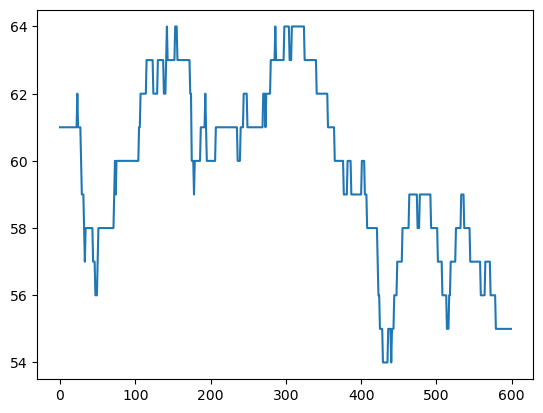

In [ ]:
plt.plot([f.shape[0] for f in frames]);

In [ ]:
frames[0].shape # N', 7:traj_idx 	frame 	x 	y 	alpha 	D 	state

(61, 7)

Load the data using the code snippet below:

This script **(1)** iterates over each file in the specified directory path containing a `.tif` extension, **(2)** reads the image using OpenCV's `cv2.imread()` function with the `IMREAD_UNCHANGED flag` indicating that the image should be loaded without any modification or conversion, and **(3)** appends the loaded image to the `images` list.

Let us visualize some frames from the training image sequence along with their corresponding segmentation mask.

The script below plots a specified number of frames distributed evenly over the training image sequence.

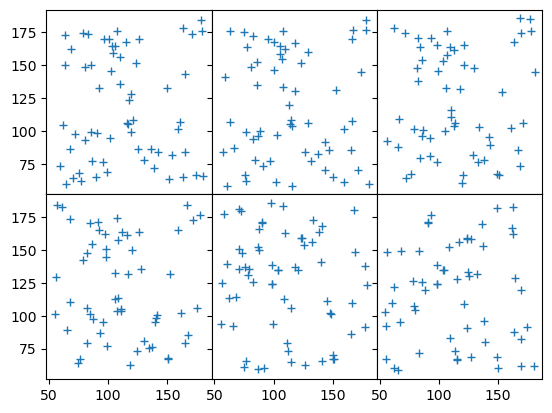

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, gridspec_kw=dict(wspace=0, hspace=0))
for t, ax in zip([0,20,40,60,300, 500], axs.flatten()):
    ax.plot(*frames[t][:,2:4].T, '+');

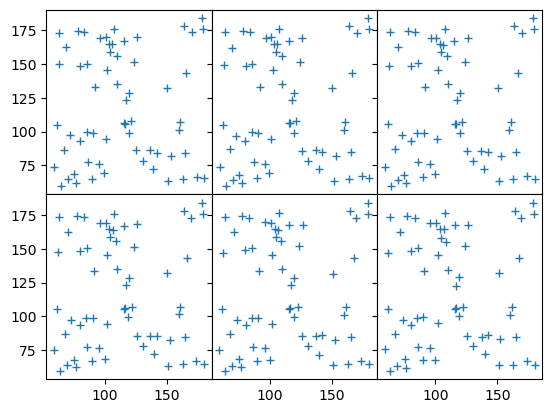

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, gridspec_kw=dict(wspace=0, hspace=0))
for t, ax in zip(list(range(6)), axs.flatten()):
    ax.plot(*frames[t][:,2:4].T, '+');

In [ ]:
# how much a particle moves from one frame to another?
disp = np.diff([frame[0,2:4] for frame in frames[:50]],axis=0)

In [ ]:
disp

array([[-0.07532378,  0.37362373],
       [-0.06331074,  0.21476655],
       [-0.29640334,  0.8159916 ],
       [ 0.02985466,  0.46241945],
       [ 0.02620055,  0.45981199],
       [-0.26873746,  0.74037621],
       [-0.25742939,  0.3710841 ],
       [ 0.19391344,  0.42946633],
       [-0.21069978,  0.66157416],
       [-0.07520269,  0.30881254],
       [-0.04301742,  0.37484555],
       [ 0.07038688,  0.5856244 ],
       [-0.17240871,  0.45033039],
       [ 0.01588464,  0.57114879],
       [-0.13899994,  0.46189428],
       [-0.06066865,  0.4667083 ],
       [ 0.1902146 ,  0.80588228],
       [-0.29845337,  0.38217171],
       [-0.18863411,  0.49898721],
       [-0.12368135,  0.88078762],
       [ 0.11219954,  0.36980169],
       [-0.40689691,  0.58269751],
       [-0.01962818,  0.50187824],
       [-0.09156967,  0.41388865],
       [ 0.24186795,  0.43053683],
       [-0.18760011,  0.38262331],
       [-0.05450634,  0.46158245],
       [-0.25091813,  0.53066261],
       [-0.00707162,

In [ ]:
disp.max()#/128

0.8807876204128746

In [ ]:
[frame[0,2:4] for frame in frames[:50]]

[array([59.35984097, 73.35519683]),
 array([59.28451719, 73.72882056]),
 array([59.22120645, 73.94358711]),
 array([58.9248031 , 74.75957871]),
 array([58.95465776, 75.22199816]),
 array([58.98085831, 75.68181015]),
 array([58.71212085, 76.42218636]),
 array([58.45469146, 76.79327046]),
 array([58.6486049 , 77.22273679]),
 array([58.43790512, 77.88431095]),
 array([58.36270243, 78.19312349]),
 array([58.31968501, 78.56796903]),
 array([58.39007189, 79.15359343]),
 array([58.21766318, 79.60392382]),
 array([58.23354783, 80.17507261]),
 array([58.09454789, 80.63696689]),
 array([58.03387923, 81.10367519]),
 array([58.22409384, 81.90955748]),
 array([57.92564047, 82.29172918]),
 array([57.73700635, 82.79071639]),
 array([57.61332501, 83.67150401]),
 array([57.72552454, 84.04130569]),
 array([57.31862763, 84.6240032 ]),
 array([57.29899945, 85.12588145]),
 array([57.20742978, 85.53977009]),
 array([57.44929773, 85.97030693]),
 array([57.26169762, 86.35293023]),
 array([57.20719128, 86.8145

In [ ]:
[frame[0,0] for frame in frames[:50]]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
disp.max()

52.752304592678186

# Create a Graph from LodeSTAR detections/ANDI videos

MAGIK models cell motion and interactions as a directed graph, where nodes represent segmented cells and edges connect spatially close cells across frames.

We will implement the `GraphFromSegmentations` class to generate a graph from the segmented video frames:

In [ ]:
import torch
from torch_geometric.data import Data


class GraphFromDetectionsTruth:
    def __init__(self, connectivity_radius, max_frame_distance):
        self.connectivity_radius = connectivity_radius       # (1)
        self.max_frame_distance  = max_frame_distance        # (2)

    def __call__(self, frames, # T, (N', F or 2)
                 data_norm,    # to normalize positions
                 relation=None):
        x, node_index_labels, frames_t = [], [], []
        # if ragged # TODO if not ragged
        for frame in frames: # (3)  # N', 7:traj_idx 	frame 	x 	y 	alpha 	D 	state
            # traj_id, frame num,  x,y, 
            index_labels, frame_t, features = frame[:,0] , frame[:,1] , frame[:,2:4]/data_norm # (4)# TODO include alpha, D state, cp as node attrb?
            
            node_index_labels.append(index_labels)           # (6)
            frames_t.append(frame_t)           # (7)
            x.append(features)                               # (5)

        node_index_labels = np.concatenate(node_index_labels)# T*N'
        frames_t          = np.concatenate(frames_t)         # T*N'
        x                 = np.concatenate(x)                # T*N',F

        # edge_index, edge_attr = self.compute_connectivity(x, frames_t) # (8)
        N_ = np.cumsum([f.shape[0] for f in frames])
        edge_index, edge_attr = self.get_edges_and_distances_in_frames(
            x[:, :2], N_, self.connectivity_radius,self.max_frame_distance)
        edge_ground_truth = self.compute_ground_truth(       # (9)
            node_index_labels, edge_index, relation)

        #edge_index = edge_index.T # not needed if using np.nonzero instead of np.argwhere
        edge_attr = edge_attr[:, None]  # distance # todo augment to be (dr,dtheta) for alpha, D, and state prediction
        edge_ground_truth = edge_ground_truth[:, None]

        graph = Data(                                       # (10)
            x          = torch.tensor(x,          dtype=torch.float),
            edge_index = torch.tensor(edge_index, dtype=torch.long),
            edge_attr  = torch.tensor(edge_attr,  dtype=torch.float),
            distance   = torch.tensor(edge_attr,  dtype=torch.float),
            frames_t   = torch.tensor(frames_t,   dtype=torch.float),  # float or int?
            traj_id    = torch.tensor(node_index_labels, dtype=torch.int),
            y          = torch.tensor(edge_ground_truth, dtype=torch.float), # float or int?
        )

        return graph

    def compute_connectivity(self, x, # T*N',F;
                             frames): # T*N'
        positions = x[:, :2] # T*N',2;
        distances = np.linalg.norm(positions[:, None] # T*N',1,2;
                                   - positions,       # T*N',2;
                                   axis=-1)           # T*N',T*N';

        frame_diff = (frames[:, None]  # T*N',1
                      - frames         # T*N'
                     ) * -1            # T*N', T*N'

        mask = (distances < self.connectivity_radius) & ( 
            (frame_diff <= self.max_frame_distance) & (frame_diff > 0)
        )

        edge_index = np.argwhere(mask) 
        edge_attr = distances[mask] 

        return edge_index, edge_attr        

    def get_edges_and_distances_in_frames(self, positions, # T*N',2
                            N_,        # =N'_t; T
                            connectivity_radius,
                            max_frame_distance:int=1 # minimum 1, the next timestep
                           ):
        """Broadcasts to allowed forthcoming frames"""
        # ideal-code:
        # positions[     :N'_0,  None] - positions[N'_0:N'_(0+max_frame_distance)]  # N'_0, N'_1+...N'_(0+max_frame_distance),2
        # positions[N'_0 :N'_1,  None] - positions[N'_1:N'_(1+max_frame_distance)]  # N'_1, N'_2+...  , 2
        # positions[N'_1 :N'_2,  None] - positions[N'_2:N'_(2+max_frame_distance)]
        # ... (T-max_frame_distance times)
        # positions[N'_i :N'_i+1,  None] - positions[N'_i+1:N'_((T-max_frame_distance)+max_frame_distance)]
        #
        # positions[N'_T-5:N'_T-4, None] - positions[N'_T-4:N'_(T-1)]
        # positions[N'_T-4:N'_T-3, None] - positions[N'_T-3:N'_T-1]
        # positions[N'_T-3:N'_T-2, None] - positions[N'_T-2:N'_T-1]
        # up to T-1 = T-1 -(T-max_frame_distance) = max_frame_distance - 1
        # positions[N'_i  :N'_i+1, None] - positions[N'_i+1:]
        T = len(N_)
        N_ = np.concatenate((np.array([0]), N_))  # T+1
        distances = []
        edges_idx = []
        for i in range(T-max_frame_distance):
            d = np.linalg.norm(positions[N_[i]  :N_[i+1],  None]
                             - positions[N_[i+1]:N_[i+(max_frame_distance+1)]],
                               axis=-1)                  # N_[i+1], N[i+2]+...
            idx = np.nonzero(d < connectivity_radius)    # tuple: 2, near
            # print('idx', idx)
            distances.append(d[idx])
            # print('d', d[idx])
            # print('N', [N_[i], N_[i+1]])
            edges_idx.append(np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]]))
            # print((np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]])).shape)
            # break
    
        for i in range(T-max_frame_distance, T-1):
            d = np.linalg.norm(positions[N_[i]  :N_[i+1],  None]
                             - positions[N_[i+1]:],
                               axis=-1)                  # N_[i+1], N[i+2]+...N[-1]
            idx = np.nonzero(d < connectivity_radius)    # tuple: 2, near
            distances.append(d[idx])
            edges_idx.append(np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]]))
    
        distances = np.concatenate(distances)            # T*near'
        edges_idx = np.concatenate(edges_idx, axis=-1)   # 2, T*near'
        return edges_idx, distances
    
    def compute_ground_truth(self, indices, edge_index, relation):
        sender   = indices[edge_index[0]] 
        receiver = indices[edge_index[1]]
        self_connections_mask = sender == receiver

        if relation is not None:
            relation_indices = relation[:, [-1, 0]] 
            relation_indices = relation_indices[relation_indices[:, 0] != 0]

            relation_mask = np.zeros(len(edge_index), dtype=bool)
            for i, (s, r) in enumerate(zip(sender, receiver)):
                if np.any((relation_indices == [s, r]).all(1)): 
                    relation_mask[i] = True
    
            ground_truth = self_connections_mask | relation_mask

            return ground_truth
        return self_connections_mask

In [ ]:
import torch
from torch_geometric.data import Data


class GraphFromDetections:
    def __init__(self, connectivity_radius, max_frame_distance):
        self.connectivity_radius = connectivity_radius       # (1)
        self.max_frame_distance  = max_frame_distance        # (2)

    def __call__(self, frames, # T, (N', F or 2)
                 data_norm,    # to normalize positions
                 relation=None):
        x, node_index_labels, frames_t = [], [], []
        for frame_t, frame in enumerate(frames): # (3)  # N', 7:traj_idx 	frame 	x 	y 	alpha 	D 	state
            features =  frame[:,:2]/data_norm
            frames_t.append([frame_t]*len(features))           # (7)
            x.append(features)                               # (5)

        frames_t          = np.concatenate(frames_t)         # T*N'
        x                 = np.concatenate(x)                # T*N',F

        # edge_index, edge_attr = self.compute_connectivity(x, frames_t) # (8)
        N_ = np.cumsum([f.shape[0] for f in frames])
        edge_index, edge_attr = self.get_edges_and_distances_in_frames(
            x[:, :2], N_, self.connectivity_radius,self.max_frame_distance)

        edge_attr = edge_attr[:, None]  # distance # todo augment to be (dr,dtheta) for alpha, D, and state prediction

        graph = Data(                                       # (10)
            x          = torch.tensor(x,          dtype=torch.float),
            edge_index = torch.tensor(edge_index, dtype=torch.long),
            edge_attr  = torch.tensor(edge_attr,  dtype=torch.float),
            distance   = torch.tensor(edge_attr,  dtype=torch.float),
            frames_t   = torch.tensor(frames_t,   dtype=torch.float),  # float or int?
        )

        return graph

    def compute_connectivity(self, x, # T*N',F;
                             frames): # T*N'
        positions = x[:, :2] # T*N',2;
        distances = np.linalg.norm(positions[:, None] # T*N',1,2;
                                   - positions,       # T*N',2;
                                   axis=-1)           # T*N',T*N';

        frame_diff = (frames[:, None]  # T*N',1
                      - frames         # T*N'
                     ) * -1            # T*N', T*N'

        mask = (distances < self.connectivity_radius) & ( 
            (frame_diff <= self.max_frame_distance) & (frame_diff > 0)
        )

        edge_index = np.argwhere(mask) 
        edge_attr = distances[mask] 

        return edge_index, edge_attr        

    def get_edges_and_distances_in_frames(self, positions, # T*N',2
                            N_,        # =N'_t; T
                            connectivity_radius,
                            max_frame_distance:int=1 # minimum 1, the next timestep
                           ):
        """Broadcasts to allowed forthcoming frames"""
        # ideal-code:
        # positions[     :N'_0,  None] - positions[N'_0:N'_(0+max_frame_distance)]  # N'_0, N'_1+...N'_(0+max_frame_distance),2
        # positions[N'_0 :N'_1,  None] - positions[N'_1:N'_(1+max_frame_distance)]  # N'_1, N'_2+...  , 2
        # positions[N'_1 :N'_2,  None] - positions[N'_2:N'_(2+max_frame_distance)]
        # ... (T-max_frame_distance times)
        # positions[N'_i :N'_i+1,  None] - positions[N'_i+1:N'_((T-max_frame_distance)+max_frame_distance)]
        #
        # positions[N'_T-5:N'_T-4, None] - positions[N'_T-4:N'_(T-1)]
        # positions[N'_T-4:N'_T-3, None] - positions[N'_T-3:N'_T-1]
        # positions[N'_T-3:N'_T-2, None] - positions[N'_T-2:N'_T-1]
        # up to T-1 = T-1 -(T-max_frame_distance) = max_frame_distance - 1
        # positions[N'_i  :N'_i+1, None] - positions[N'_i+1:]
        T = len(N_)
        N_ = np.concatenate((np.array([0]), N_))  # T+1
        distances = []
        edges_idx = []
        for i in range(T-max_frame_distance):
            d = np.linalg.norm(positions[N_[i]  :N_[i+1],  None]
                             - positions[N_[i+1]:N_[i+(max_frame_distance+1)]],
                               axis=-1)                  # N_[i+1], N[i+2]+...
            idx = np.nonzero(d < connectivity_radius)    # tuple: 2, near
            # print('idx', idx)
            distances.append(d[idx])
            # print('d', d[idx])
            # print('N', [N_[i], N_[i+1]])
            edges_idx.append(np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]]))
            # print((np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]])).shape)
            # break
    
        for i in range(T-max_frame_distance, T-1):
            d = np.linalg.norm(positions[N_[i]  :N_[i+1],  None]
                             - positions[N_[i+1]:],
                               axis=-1)                  # N_[i+1], N[i+2]+...N[-1]
            idx = np.nonzero(d < connectivity_radius)    # tuple: 2, near
            distances.append(d[idx])
            edges_idx.append(np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]]))
    
        distances = np.concatenate(distances)            # T*near'
        edges_idx = np.concatenate(edges_idx, axis=-1)   # 2, T*near'
        return edges_idx, distances

In [ ]:
graph_constructor = GraphFromDetections(connectivity_radius=0.05, max_frame_distance=2)

In [ ]:
x, node_index_labels, frames_t = [], [], []
# if ragged # TODO if not ragged
for frame in frames[:20]: # (3)  # N', 7:traj_idx 	frame 	x 	y 	alpha 	D 	state
    # traj_id, frame num,  x,y, 
    index_labels, frame_t, features = frame[:, 0] , frame[:, 1] , frame[:, 2:4] # (4)# TODO include alpha, D state, cp as node attrb?
    node_index_labels.append(index_labels)           # (6)
    frames_t.append(frame_t)  # [[0,0],[1,1]...]         # (7)
    x.append(features)                               # (5)
node_index_labels = np.concatenate(node_index_labels) # N'*T
frames_t          = np.concatenate(frames_t)   # N'*T, F
x                 = np.concatenate(x)        # N'*T, F

In [ ]:
x.shape, node_index_labels.shape, frames_t.shape

((1220, 2), (1220,), (1220,))

In [ ]:
positions = x[:, :2] # x,y, N, 2
distances = np.linalg.norm(positions[:, None] - positions, axis=-1) # N,N distances

In [ ]:
positions.shape, distances.shape

((1220, 2), (1220, 1220))

In [ ]:
# pdist??

In [ ]:
frame_diff = (frames_t[:, None] - frames_t) * -1  # 2, T,T

In [ ]:
frame_diff.shape

(1220, 1220)

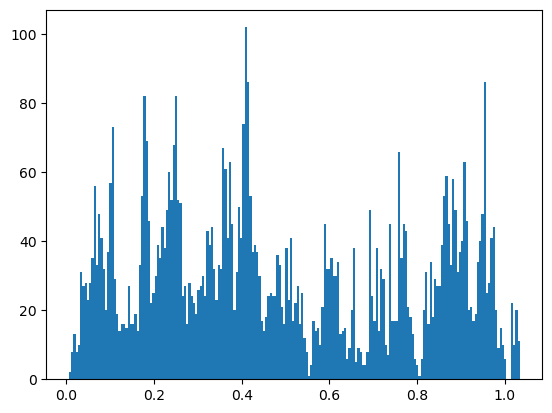

In [ ]:
plt.hist((positions.reshape(-1)-53.78)/128,200);

In [ ]:
from scipy.spatial.distance import pdist

In [ ]:
d = pdist((positions-53.786186)/128)

In [ ]:
d.shape, positions.shape[0]*(positions.shape[0]-1)//2, positions.shape[0]**2

((4438710,), 4438710, 8880400)

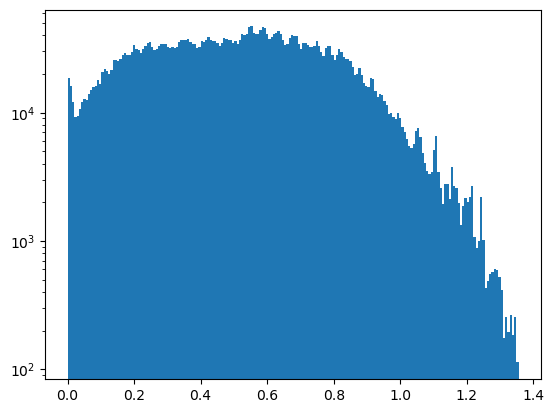

In [ ]:
plt.hist(d.reshape(-1),200, log=1);

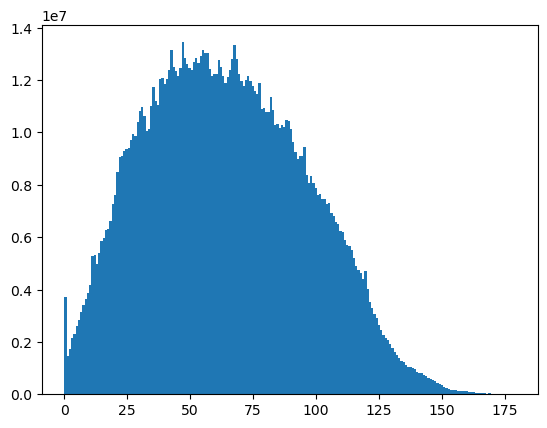

In [ ]:
plt.hist(distances.reshape(-1),200);

In [ ]:
connectivity_radius = 3 #/128 # normalized pixels

In [ ]:
frame_diff[0]

array([-0., -0., -0., ..., 19., 19., 19.])

In [ ]:
mask = (distances < connectivity_radius) & ( 
    (frame_diff <= 2) & (frame_diff > 0)
)

In [ ]:
mask.shape, np.prod(mask.shape)

((1220, 1220), 1488400)

In [ ]:
edge_index = np.argwhere(mask) 
edge_attr  = distances[mask] 

In [ ]:
edge_index.shape, edge_attr.shape

((2345, 2), (2345,))

The `GraphFromSegmentations` class is initialized with two parameters: **(1)** `connectivity_radius` and **(2)** `max_frame_distance`. These parameters play an important role in establishing the spatial and temporal thresholds necessary for determining connectivity between nodes within the graph structure.

In the call method, `GraphFromSegmentations` receives two inputs: the segmented video frames (`segmentations`) and the parent-child relationships between cells (`relation`). **(3)** The method identifies separate objects in each frame of the segmented video data using their index labels. Next, **(4)** it calculates relevant features such as normalized centroids and eccentricity. **(5)** These features are stored in a set called `x`. The algorithm repeats this process for every object in the frame, creating a collection of node features (`x`), **(6)** index labels (`node_index_labels`), and **(7)** their corresponding frame numbers (`frames`), all poised for further processing.

Leveraging the extracted node features, **(8)** `GraphFromSegmentations` proceeds to calculate pairwise distances between the positions of the nodes. Simultaneously, it computes the temporal difference between frames. Based on the specified thresholds (`connectivity_radius` and `max_frame_distance`), it identifies nodes that are both spatially and temporally close. The result is a set of edge indices (`edge_index`) and corresponding distances (`edge_attr`) representing the connectivity between nodes.

Finally, **(9)** the ground-truth edges are computed. The generated graph includes a redundant number of edges with respect to the actual associations between cells. MAGIK aims to prune the redundant edges while retaining the true connections. Therefore, the ground truth for each edge is a binary value indicating whether an edge should connect two detections, i.e., an edge classification problem. `GraphFromSegmentations` defines the ground truth by comparing the node index labels and parent-child relationships. Firstly, it identifies self-connections where sender and receiver nodes have the same node index labels. Next, it explores the cell relationships to find relational connections, such as cell divisions. The ground truths are derived from the combination of self-connections and relational connections. 

**(10)** `GraphFromSegmentations` constructs a PyTorch Data object using node features, edge indices, attributes, distances, frames, and ground truth. This object encapsulates all necessary information for training and testing.

Instantiate the `GraphFromSegmentations` class with a connectivity radius of 0.2 (equivalent to 20% of the image size) and a maximum frame distance of 2 to reconnect cells not detected in consecutive frames.

In [ ]:
3/128/100

0.000234375

In [ ]:
graph_constructor = GraphFromDetections(connectivity_radius=0.05, max_frame_distance=2)

We now construct the training graph using `graph_constructor`:

In [ ]:
frames.shape

(600,)

In [ ]:
train_graph = graph_constructor(frames[:50], 128)

Use the following code to explore the graph data structure:

In [ ]:
print("Number of nodes:", len(train_graph.x))
print("Number of edges:", len(train_graph.edge_index[0]))

Number of nodes: 2980
Number of edges: 16548


In [ ]:
graph_constructor.connectivity_radius

0.1

Maximum D is around 10^4 this translates into pixels/frame.

Text(0, 0.5, 'y')

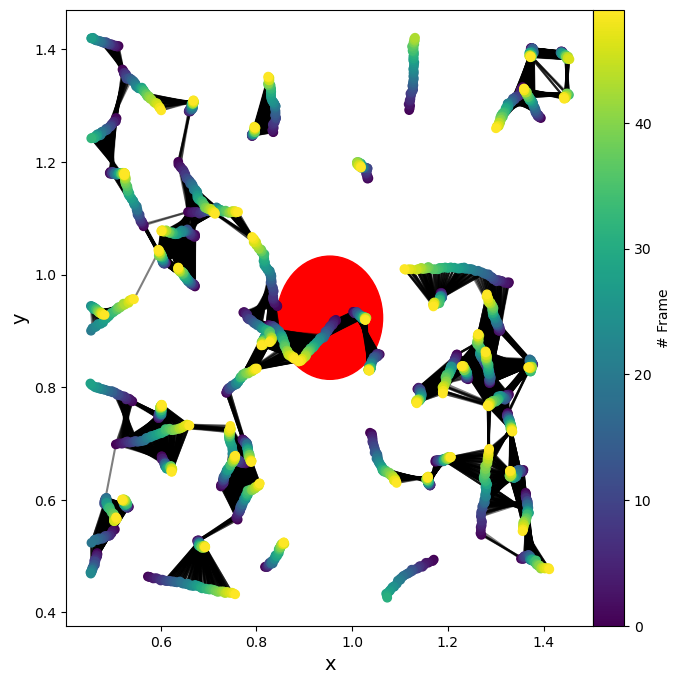

In [ ]:
plt.figure(figsize=(8, 8))
circle1 = plt.Circle((0.5, 0.5), graph_constructor.connectivity_radius,
                     transform=plt.gca().transAxes, color='r')

plt.gca().add_artist(circle1)
for i, j in train_graph.edge_index.T:
    plt.plot([train_graph.x[i, 1], train_graph.x[j, 1]],
             [train_graph.x[i, 0], train_graph.x[j, 0]],
             c="black",alpha=0.5,)

plt.scatter(train_graph.x[:, 1], train_graph.x[:, 0],
            c=train_graph.frames_t, cmap="viridis", zorder=10,)
cb = plt.colorbar(pad=0, label='# Frame')
plt.xlabel("x", fontsize=14); plt.ylabel("y", fontsize=14);

This scatter plot depicts a graph with nodes represented as dots. The $x$ and $y$ coordinates represent the normalized node centroids. The color of each dot corresponds to the frame number, as shown on the color bar. The black lines on the plot illustrate the edges.

# Augmented Dataset


The training dataset consists of a single graph derived from the training video sequence. Although this may initially appear as limited data, it proves to be ample for effectively training the MAGIK model. To address the scarcity of data, we adopt a strategic approach of augmenting the training graph by splitting it into smaller temporal subgraphs.

The `CellTracingDataset` implements this augmentation strategy by dividing the training graph into smaller subgraphs parameterized by the `window_size`parameter:

In [ ]:
from torch.utils.data import Dataset


class CellTracingDataset(Dataset):
    def __init__(self, graph, window_size, dataset_size, transform=None):
        self.graph = graph

        self.window_size = window_size # (1)
        self.dataset_size = dataset_size

        frames, edge_index = graph.frames_t, graph.edge_index
        self.pair_frames = torch.stack(
            [frames[edge_index[0, :]], frames[edge_index[1, :]]], axis=1
        )
        self.frames = frames
        self.max_frame = frames.max()

        self.transform = transform 

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        frame_idx = np.random.randint(self.window_size, self.max_frame + 1) # (2)

        start_frame = frame_idx - self.window_size
        node_mask = (self.frames >= start_frame) & (self.frames < frame_idx) # (3)
        x = self.graph.x[node_mask] # (4)

        edge_mask = (self.pair_frames >= start_frame) & (self.pair_frames < frame_idx) # (5)
        edge_mask = edge_mask.all(axis=1) 

        edge_index = self.graph.edge_index[:, edge_mask] # (6)
        edge_index -= edge_index.min() 

        edge_attr = self.graph.edge_attr[edge_mask] # (7)

        # sample ground truth edges
        ground_truth_edges = self.graph.y[edge_mask] # (8)

        graph = Data( # (9)
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            distance=edge_attr, # needed???
            y=ground_truth_edges,
        )

        if self.transform: # (10)
            graph = self.transform(graph)

        return graph

**(1)** The `window_size` parameter determines the number of frames in each subgraph. **(2)** The dataset generates subgraphs by randomly sliding a window across the training graph. The subgraph is constructed by extracting **(3-4)** nodes and **(5-8)** edges within the window. **(9)** The dataset returns the subgraph as a PyTorch Data object. 

To further enhance the training dataset, additional augmentations can be applied to the subgraphs. The `CellTracingDataset` class provides the flexibility to include custom augmentations by specifying the `transform` parameter. 

The following code snippet defines two augmentations: `RandomRotation` and `RandomFlip`.

In [ ]:
import torch
import math


class RandomRotation: # (1)
    def __call__(self, graph):
        graph = graph.clone()
        centered_features = graph.x[:, :2] - 0.5

        angle = np.random.rand() * 2 * np.pi
        rotation_matrix = torch.tensor(
            [
                [math.cos(angle), -math.sin(angle)],
                [math.sin(angle),  math.cos(angle)],
            ]
        )
        rotated_features = torch.matmul(centered_features, rotation_matrix)

        graph.x[:, :2] = rotated_features + 0.5
        return graph
    
class RandomFlip: # (2)
    def __call__(self, graph):
        graph = graph.clone()
        centered_features = graph.x[:, :2] - 0.5

        if np.random.randint(2):
            centered_features[:, 0] *= -1
        
        if np.random.randint(2):
            centered_features[:, 1] *= -1
        
        graph.x[:, :2] = centered_features + 0.5
        return graph

**(1)** The `RandomRotation` augmentation function randomly rotates the positional features of the nodes within the subgraph. 

Likewise, **(2)** the `RandomFlip` augmentation randomly flips the positional features of the nodes along the $x$-axis or $y$-axis.

In [ ]:
train_graph

Data(x=[2980, 2], edge_index=[2, 16548], edge_attr=[16548, 1], y=[16548, 1], frames_t=[2980])

In [ ]:
from torchvision import transforms

train_dataset = CellTracingDataset(
    train_graph,
    window_size=5,
    dataset_size=512, # (1)
    transform=transforms.Compose([RandomRotation(), RandomFlip()]),
)

**(1)** `dataset_size` controls the number of subgraphs generated from the training graph per epoch. 

The training dataset is instantiated with a window size of 5 frames and a dataset size of 512 subgraphs.

In [ ]:
train_dataset[0]

Data(x=[302, 2], edge_index=[2, 1138], edge_attr=[1138, 1], y=[1138, 1], distance=[1138, 1])

# Data Loader

Now, we proceed to define the data loaders, which are responsible for feeding the data to the model during training.

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
next(iter(train_loader))

DataBatch(x=[2365, 2], edge_index=[2, 9442], edge_attr=[9442, 1], y=[9442, 1], distance=[9442, 1], batch=[2365], ptr=[9])

# Build MAGIK

The following code snippet defines the [MAGIK](https://www.nature.com/articles/s42256-022-00595-0) model:

In [ ]:
from deeplay import GraphToEdgeMAGIK
import torch.nn as nn

model = GraphToEdgeMAGIK([96,] * 4, 1, out_activation=nn.Sigmoid) # (1)

In [ ]:
model

GraphToEdgeMAGIK(
  (encoder): Parallel(
    (0-1): 2 x MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): Layer[LazyLinear](out_features=96, bias=True)
          (activation): Layer[Identity]()
        )
      )
    )
  )
  (backbone): MessagePassingNeuralNetwork(
    (blocks): LayerList(
      (0): LearnableDistancewWeighting(init_sigma=0.12, init_beta=4.0)
      (1-4): 4 x TransformPropagateUpdate(
        (transform): Transform(
          (combine): Cat()
          (layer): Layer[LazyLinear](out_features=96)
          (activation): Layer[ReLU]()
        )
        (propagate): WeightedSum()
        (update): Update(
          (combine): Cat()
          (layer): Layer[LazyLinear](out_features=96)
          (activation): Layer[ReLU]()
        )
      )
    )
  )
  (selector): FromDict(edge_attr)
  (pool): Layer[Identity]()
  (head): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_featur

In [ ]:
model.encoder[0].configure(hidden_features=[32, 64], out_features=96, out_activation=nn.ReLU) # (2)
model.encoder[1].configure(hidden_features=[32, 64], out_features=96, out_activation=nn.ReLU) # (3)
model.head.configure(hidden_features=[64, 32])

print(model) # (4)

GraphToEdgeMAGIK(
  (encoder): Parallel(
    (0-1): 2 x MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): Layer[LazyLinear](out_features=32, bias=True)
          (activation): Layer[ReLU]()
        )
        (1): LinearBlock(
          (layer): Layer[Linear](in_features=32, out_features=64, bias=True)
          (activation): Layer[ReLU]()
        )
        (2): LinearBlock(
          (layer): Layer[Linear](in_features=64, out_features=96, bias=True)
          (activation): Layer[ReLU]()
        )
      )
    )
  )
  (backbone): MessagePassingNeuralNetwork(
    (blocks): LayerList(
      (0): LearnableDistancewWeighting(init_sigma=0.12, init_beta=4.0)
      (1-4): 4 x TransformPropagateUpdate(
        (transform): Transform(
          (combine): Cat()
          (layer): Layer[LazyLinear](out_features=96)
          (activation): Layer[ReLU]()
        )
        (propagate): WeightedSum()
        (update): Update(
          (combine): Cat()
     

**(1)** Instantiates a simplified version of MAGIK, which is a message-passing neural network. The model has four layers, and each layer contains 96 hidden features. Along with the message-passing layers, the model also includes a node encoder, an edge encoder, and a classification head. 

**(2-3)** The node and edge encoder are configured with three hidden layers, each with 32, 64, and 96 hidden features. The classification head consists of two hidden layers with 64 and 32 hidden features and a final output layer with a single output and a sigmoid activation function. **(4)** Prints the model summary.

MAGIK is similar to message-passing neural networks that we have seen in previous examples. However, the main difference is that MAGIK implements a local attention mechanism that allows the model to concentrate on specific nodes and edges during message passing. This mechanism comes into play when aggregating messages to a node. Each message's contribution has a weight that depends on the distance between the connected nodes through a function with learnable parameters defining a learnable local receptive field. With this mechanism, MAGIK can focus on relevant distance-based features during message passing, which is crucial for cell tracking tasks.

In [ ]:
model.forward??

Signature: model.forward(x)
Docstring:
Define the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(self, x):
        x = self.encoder(x)
        x = self.backbone(x)
        x = self.selector(x)
        x = self.pool(x)
        x = self.head(x)
        return x
File:      /media/scratrch_data/gfernandez/deeplay/deeplay/models/gnn/mpm.py
Type:      method

In [ ]:
model(train_dataset[0])

TypeError: MultiLayerPerceptron.forward() got an unexpected keyword argument 'overwrite_output'

# Train MAGIK

Use the following code snippet to train the model:

In [ ]:
from deeplay import BinaryClassifier, Adam, Trainer

classifier = BinaryClassifier(model=model, optimizer=Adam(lr=1e-3))
classifier = classifier.build() # changed create by build!!!
# This create makes changes to the model and initializes it wrongly, not with data
# e.g., first MLP has input dim 32 instead of the number of features of the data.

In [ ]:
classifier.model

GraphToEdgeMAGIK(
  (encoder): Parallel(
    (0-1): 2 x MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): LazyLinear(in_features=0, out_features=32, bias=True)
          (activation): ReLU()
        )
        (1): LinearBlock(
          (layer): Linear(in_features=32, out_features=64, bias=True)
          (activation): ReLU()
        )
        (2): LinearBlock(
          (layer): Linear(in_features=64, out_features=96, bias=True)
          (activation): ReLU()
        )
      )
    )
  )
  (backbone): MessagePassingNeuralNetwork(
    (blocks): LayerList(
      (0): LearnableDistancewWeighting(init_sigma=0.12, init_beta=4.0)
      (1-4): 4 x TransformPropagateUpdate(
        (transform): Transform(
          (combine): Cat()
          (layer): LazyLinear(in_features=0, out_features=96, bias=True)
          (activation): ReLU()
        )
        (propagate): WeightedSum()
        (update): Update(
          (combine): Cat()
          (layer): L

In [ ]:
trainer = Trainer(max_epochs=10)
trainer.fit(classifier, train_loader)

/home/gfernandez/miniforge3/envs/steproids/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ BCELoss          │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ GraphToEdgeMAGIK │ 25.0 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 25.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 25.0 K                                                                                               
Total estimated model params size (MB): 0

Output()

/home/gfernandez/miniforge3/envs/steproids/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


In [ ]:
# save model
torch.save(classifier.state_dict(), "MAGIK_20240714.pth") 

# Evaluate MAGIK

Once the model is trained, we can evaluate its performance on the test dataset. 

We start by loading the test data:

In [ ]:
! ls '/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/exp_7512/'

ensemble_labels.txt  ens_labs_fov_0.txt  traj_labs_fov_0.txt  trajs_fov_0.csv


In [ ]:
create_frame_dataset(Path('/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/exp_7512/trajs_fov_0.csv'))

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/exp_7512/frames_fov.npy


In [ ]:
test_detections_ = np.load('/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/exp_7512/frames_fov.npy',
                 mmap_mode=None, allow_pickle=True)

In [ ]:
test_detections_.shape

(600,)

In [ ]:
test_detections = test_detections_[:50]

In [ ]:
test_detections.shape

(50,)

In [ ]:
sum([t.shape[0] for t in test_detections])

2774

We now construct the test graph using `graph_constructor`:

In [ ]:
test_graph = graph_constructor(test_detections, 128)

In [ ]:
test_graph

Data(x=[2774, 2], edge_index=[2, 8170], edge_attr=[8170, 1], y=[8170, 1], distance=[8170, 1], frames_t=[2774], traj_id=[2774])

In [ ]:
test_graph.frames_t

tensor([ 0.,  0.,  0.,  ..., 49., 49., 49.])

After creating the test graph, we can assess the model's performance by calculating the f1-score of the predicted and ground-truth edge classification:

In [ ]:
from deeplay import GraphToEdgeMAGIK
import torch.nn as nn
# load model
# instantiate model with GPU if available
with torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'):
    model = GraphToEdgeMAGIK([96,] * 4, 1, out_activation=nn.Sigmoid) # (1)

model.encoder[0].configure(hidden_features=[32, 64], out_features=96, out_activation=nn.ReLU) # (2)
model.encoder[1].configure(hidden_features=[32, 64], out_features=96, out_activation=nn.ReLU) # (3)
model.head.configure(hidden_features=[64, 32])

from deeplay import BinaryClassifier, Adam, Trainer

classifier = BinaryClassifier(model=model, optimizer=Adam(lr=1e-3))
classifier = classifier.build()

# load weights
classifier.load_state_dict(torch.load("MAGIK_20240714.pth"))

In [ ]:
from sklearn.metrics import f1_score
classifier.eval()
pred = classifier(test_graph) # needs attribute distance!!!
predictions = pred.detach().numpy() > 0.5

ground_truth = test_graph.y

score = f1_score(ground_truth, predictions)
print(f"Test F1 score: {score}")

Test F1 score: 0.9996279069767442


You can expect an f1-score of approximately 0.99 on the test graph, exhibiting the model's ability to accurately predict cell temporal associations.

Note that MAGIK does not output cell trajectories, but a graph structure that shows the connections between cells across frames. To generate cell trajectories, a post-processing algorithm is applied to the predicted graph structure.

The `compute_trajectories` function below implements a simple post-processing algorithm to compute cell trajectories from MAGIK predictions:

In [ ]:
import networkx as nx

class compute_trajectories:

    def __call__(self, graph, predictions):
        pruned_edges = self.prune_edges(graph, predictions)

        pruned_graph = nx.Graph()
        pruned_graph.add_edges_from(pruned_edges)

        trajectories = list(nx.connected_components(pruned_graph))

        return trajectories

    def prune_edges(self, graph, predictions):
        pruned_edges = []

        frame_pairs = np.stack(
            [graph.frames_t[graph.edge_index[0]], graph.frames_t[graph.edge_index[1]]],
            axis=1,
        )

        senders = np.unique(graph.edge_index[0])
        for sender in senders: 
            sender_mask = graph.edge_index[0] == sender # (1)
            candidate = predictions[sender_mask] == True # (2)

            frame_diff = frame_pairs[sender_mask, 1] - frame_pairs[sender_mask, 0]
            candidates_frame_diff = frame_diff[candidate]

            if not np.any(candidate):
                continue
            else:
                candidate_min_frame_diff = candidates_frame_diff.min()
            
            candidate_edge_index = graph.edge_index[:, sender_mask][ # (3)
                :, candidate & (frame_diff == candidate_min_frame_diff)
            ]
            candidate_edge_index = candidate_edge_index.reshape(-1, 2)

            if len(candidate_edge_index) == 1: # (4)
                pruned_edges.append(tuple(*candidate_edge_index.numpy()))

        return pruned_edges

post_processor = compute_trajectories()

**(1)** The algorithm starts by selecting a node in the first frame ($t=0$) and then links it to other nodes in the following frames, **(2)** using only edges labeled as "linked" by MAGIK. **(3)** If there are no "linked" edges connecting the sender node at time $t$ to any receiver nodes at time $t+1$, the algorithm checks future frames up to a maximum time delay. If no "linked" edges are found within this timeframe, the trajectory ends.

When a sender node has two "linked" edges connecting it to two receiver nodes in a later frame, it's identified as a division. In this case, **(4)** the algorithm creates two new trajectories. This process repeats until all "linked" edges are dealt with.

In [ ]:
trajectories = post_processor(test_graph, predictions.squeeze())

In [ ]:
trajectories # list of dicts with N' ints? # idx refering to T*N'

[{0,
  54,
  108,
  162,
  216,
  270,
  324,
  378,
  432,
  486,
  540,
  594,
  648,
  702,
  756,
  811,
  866,
  921,
  976,
  1031,
  1086,
  1141,
  1196,
  1251,
  1306,
  1361,
  1416,
  1471,
  1527,
  1583,
  1639,
  1695,
  1751,
  1807,
  1863,
  1919,
  1975,
  2031,
  2087,
  2143,
  2199,
  2256,
  2313,
  2370,
  2427,
  2484,
  2542,
  2600,
  2658,
  2716},
 {1,
  55,
  109,
  163,
  217,
  271,
  325,
  379,
  433,
  487,
  541,
  595,
  649,
  703,
  757,
  812,
  867,
  922,
  977,
  1032,
  1087,
  1142,
  1197,
  1252,
  1307,
  1362,
  1417,
  1472,
  1528,
  1584,
  1640,
  1696,
  1752,
  1808,
  1864,
  1920,
  1976,
  2032,
  2088,
  2144,
  2200,
  2257,
  2314,
  2371,
  2428,
  2485,
  2543,
  2601,
  2659,
  2717},
 {2,
  56,
  110,
  164,
  218,
  272,
  326,
  380,
  434,
  488,
  542,
  596,
  650,
  704,
  758,
  813,
  868,
  923,
  978,
  1033,
  1088,
  1143,
  1198,
  1253,
  1308,
  1363,
  1418,
  1473,
  1529,
  1585,
  1641,
  1697,
  1753,


Get each trajectory with traj_id, frame_t, x, y

In [ ]:
trajs_idx_cat = trajectories

In [ ]:
trajs = []
# traj_id, frames_t, coordinates_sorted = [],[],[]
for traj_idx_cat in trajs_idx_cat:
    t = sorted (traj_idx_cat) # list
    # coordinates_sorted.append(test_graph.x[t].numpy()) # T',2
    # traj_id.append(test_graph.traj_id[t].numpy())              # T',
    # frames_t.append(test_graph.frames_t[t].numpy())            # T',
    trajs.append(np.concatenate((test_graph.traj_id[t].numpy()[:,None],
                                 test_graph.frames_t[t].numpy()[:,None],
                                 test_graph.x[t].numpy()),  # T',2
                                axis=-1))

In [ ]:
trajs[0]

array([[ 0.        ,  0.        ,  1.16138327,  1.12706316],
       [ 0.        ,  1.        ,  1.16130328,  1.12694168],
       [ 0.        ,  2.        ,  1.16025317,  1.1258539 ],
       [ 0.        ,  3.        ,  1.16185331,  1.12600458],
       [ 0.        ,  4.        ,  1.16182721,  1.12806618],
       [ 0.        ,  5.        ,  1.16135848,  1.13048148],
       [ 0.        ,  6.        ,  1.16243792,  1.12901807],
       [ 0.        ,  7.        ,  1.1612134 ,  1.12963068],
       [ 0.        ,  8.        ,  1.1621027 ,  1.12732911],
       [ 0.        ,  9.        ,  1.15925956,  1.12900829],
       [ 0.        , 10.        ,  1.16020751,  1.12680066],
       [ 0.        , 11.        ,  1.16027427,  1.12640858],
       [ 0.        , 12.        ,  1.16132903,  1.12997627],
       [ 0.        , 13.        ,  1.16208446,  1.13010812],
       [ 0.        , 14.        ,  1.16232991,  1.12911332],
       [ 0.        , 15.        ,  1.16374362,  1.13098276],
       [ 0.        , 16.

In [ ]:
traj_id[40]

array([57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
       57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
       57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57],
      dtype=int32)

In [ ]:
frames_t[0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.],
      dtype=float32)

In [ ]:
coordinates_sorted = test_graph.x[sorted(trajectories[idx])]

Finally, we proceed to visualize the computed cell trajectories on top of the segmented video frames:

In [ ]:
test_graph

Data(x=[2774, 2], edge_index=[2, 8170], edge_attr=[8170, 1], y=[8170, 1], distance=[8170, 1], frames_t=[2774], traj_id=[2774])

In [ ]:
test_graph.traj_id

tensor([ 0,  1,  3,  ..., 71, 72, 73], dtype=torch.int32)

In [ ]:
df_test = pd.read_csv(Path('/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/exp_7512/trajs_fov_0.csv'),
                 engine='pyarrow')

In [ ]:
df_test[df_test['traj_idx']==0][['x','y']].to_numpy()[:50]/128

(50, 2)

In [ ]:
# for idx, t in enumerate(trajectories):
idx = 0
traj_idx_frame0 = df_test[df_test['frame']==0]['traj_idx'].to_numpy(dtype=int)

In [ ]:
for f in frames:
    

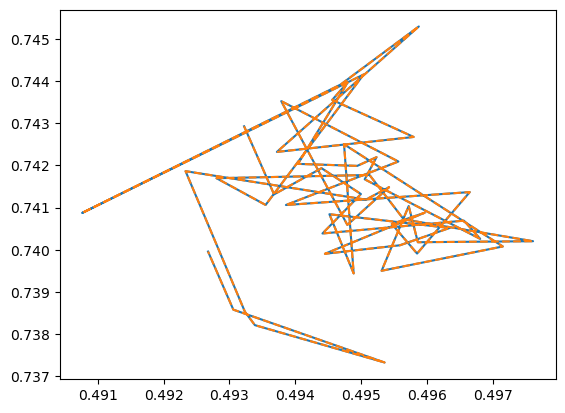

In [ ]:
idx+=1 # traj idx
# from set to list maintaing order
coordinates_sorted = test_graph.x[sorted(trajectories[idx])]#[test_graph.frames_t[list(trajectories[idx])].sort().indices]
plt.plot(*coordinates_sorted.T);
plt.plot(*(df_test[df_test['traj_idx']==traj_idx_frame0[idx]][['x','y']].to_numpy()[:50]/128).T, '--');
# plt.plot(test_detections[idx+1][:,2:4]/128); # detections are ordered by frame!!!

In [ ]:
df_test[df_test['D']>1]

,traj_idx,frame,x,y,alpha,D,state


In [ ]:
df_test['D']

0        0.008964
1        0.008964
2        0.008964
3        0.008964
4        0.008964
           ...   
33369    0.022117
33370    0.022117
33371    0.022117
33372    0.022117
33373    0.022117
Name: D, Length: 33374, dtype: float64

In [ ]:
df_test[df_test['frame']==0]['traj_idx'].to_numpy(dtype=int)

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 16, 17, 19, 21, 22,
       23, 24, 25, 26, 27, 31, 32, 33, 34, 35, 36, 37, 38, 42, 43, 44, 45,
       49, 50, 51, 53, 54, 55, 57, 59, 60, 61, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73])

In [ ]:
df_test[df_test['traj_idx']==idx]#[['x','y']].to_numpy()

,traj_idx,frame,x,y,alpha,D,state
1200,2.0,327.0,56.613906,139.588094,1.099948,0.028421,2.0
1201,2.0,328.0,56.634362,139.704820,1.099948,0.028421,2.0
1202,2.0,329.0,56.867982,139.669384,1.099948,0.028421,2.0
1203,2.0,330.0,56.860021,139.629747,1.099948,0.028421,2.0
1204,2.0,331.0,56.645785,139.385323,1.099948,0.028421,2.0
1205,2.0,332.0,56.400104,139.532760,1.099948,0.028421,2.0
1206,2.0,333.0,56.096537,139.588834,1.099948,0.028421,2.0
1207,2.0,334.0,56.211229,139.733085,1.099948,0.028421,2.0
1208,2.0,335.0,56.476478,139.745961,1.099948,0.028421,2.0
1209,2.0,336.0,56.062164,139.479333,1.099948,0.028421,2.0


In [ ]:
trajectories[2]

{2,
 56,
 110,
 164,
 218,
 272,
 326,
 380,
 434,
 488,
 542,
 596,
 650,
 704,
 758,
 813,
 868,
 923,
 978,
 1033,
 1088,
 1143,
 1198,
 1253,
 1308,
 1363,
 1418,
 1473,
 1529,
 1585,
 1641,
 1697,
 1753,
 1809,
 1865,
 1921,
 1977,
 2033,
 2089,
 2145,
 2201,
 2258,
 2315,
 2372,
 2429,
 2486,
 2544,
 2602,
 2660,
 2718}

In [ ]:
sorted(trajectories[2])

[2,
 56,
 110,
 164,
 218,
 272,
 326,
 380,
 434,
 488,
 542,
 596,
 650,
 704,
 758,
 813,
 868,
 923,
 978,
 1033,
 1088,
 1143,
 1198,
 1253,
 1308,
 1363,
 1418,
 1473,
 1529,
 1585,
 1641,
 1697,
 1753,
 1809,
 1865,
 1921,
 1977,
 2033,
 2089,
 2145,
 2201,
 2258,
 2315,
 2372,
 2429,
 2486,
 2544,
 2602,
 2660,
 2718]

In [ ]:
list(trajectories[2])

[1921,
 2,
 1033,
 650,
 1418,
 2315,
 272,
 1809,
 2201,
 923,
 1308,
 542,
 2718,
 1697,
 164,
 2089,
 2602,
 813,
 1198,
 1585,
 434,
 2486,
 56,
 1977,
 704,
 1088,
 1473,
 2372,
 326,
 1865,
 978,
 1363,
 596,
 2258,
 1753,
 218,
 2145,
 868,
 1253,
 2660,
 488,
 1641,
 110,
 2544,
 2033,
 758,
 1143,
 1529,
 380,
 2429]

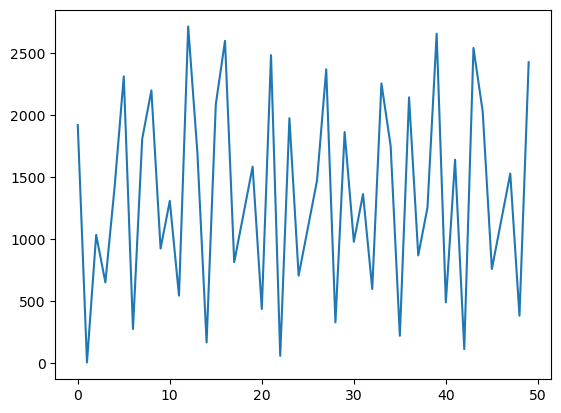

In [ ]:
plt.plot(list(trajectories[2]));

In [ ]:
test_graph

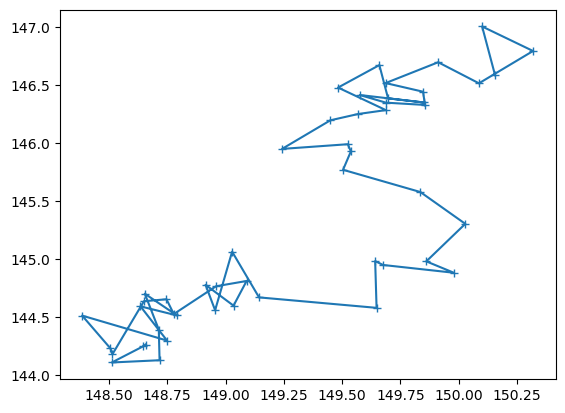

In [ ]:
plt.plot(*(df_test[df_test['traj_idx']==0][['x','y']].to_numpy()[:50]).T,'-+');

In [ ]:
test_graph.frames_t[list(trajectories[0])]#.sort()

tensor([ 0., 19., 12., 26., 42.,  5., 33., 40., 17., 24., 10., 49., 31.,  3.,
        38., 47., 15., 22., 29.,  8., 45.,  1., 36., 13., 20., 27., 43.,  6.,
        34., 18., 25., 11., 41., 32.,  4., 39., 16., 23., 48.,  9., 30.,  2.,
        46., 37., 14., 21., 28.,  7., 44., 35.])

In [ ]:
test_graph.frames_t[list(trajectories[0])].sort().indices

tensor([ 0, 21, 41, 13, 34,  5, 27, 47, 19, 39, 10, 31,  2, 23, 44, 16, 36,  8,
        29,  1, 24, 45, 17, 37,  9, 30,  3, 25, 46, 18, 40, 12, 33,  6, 28, 49,
        22, 43, 14, 35,  7, 32,  4, 26, 48, 20, 42, 15, 38, 11])

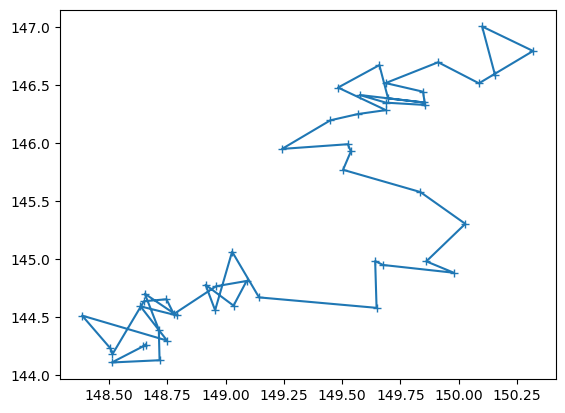

In [ ]:
plt.plot(*(test_graph.x[list(trajectories[0])][test_graph.frames_t[list(trajectories[0])].sort().indices]*128).T,'-+');

# Linking detections from LodeSTAR

In [ ]:
import torch
from torch_geometric.data import Data


class GraphFromDetections:
    def __init__(self, connectivity_radius, max_frame_distance):
        self.connectivity_radius = connectivity_radius       # (1)
        self.max_frame_distance  = max_frame_distance        # (2)

    def __call__(self, frames, # T, (N', F or 2)
                 data_norm,    # to normalize positions
                 relation=None):
        x, node_index_labels, frames_t = [], [], []
        for frame_t, frame in enumerate(frames): # (3)  # N', 7:traj_idx 	frame 	x 	y 	alpha 	D 	state
            features =  frame[:,:2]/data_norm
            frames_t.append([frame_t]*len(features))           # (7)
            x.append(features)                               # (5)

        frames_t          = np.concatenate(frames_t)         # T*N'
        x                 = np.concatenate(x)                # T*N',F

        # edge_index, edge_attr = self.compute_connectivity(x, frames_t) # (8)
        N_ = np.cumsum([f.shape[0] for f in frames])
        edge_index, edge_attr = self.get_edges_and_distances_in_frames(
            x[:, :2], N_, self.connectivity_radius,self.max_frame_distance)

        edge_attr = edge_attr[:, None]  # distance # todo augment to be (dr,dtheta) for alpha, D, and state prediction

        graph = Data(                                       # (10)
            x          = torch.tensor(x,          dtype=torch.float),
            edge_index = torch.tensor(edge_index, dtype=torch.long),
            edge_attr  = torch.tensor(edge_attr,  dtype=torch.float),
            distance   = torch.tensor(edge_attr,  dtype=torch.float),
            frames_t   = torch.tensor(frames_t,   dtype=torch.float),  # float or int?
        )

        return graph

    def compute_connectivity(self, x, # T*N',F;
                             frames): # T*N'
        positions = x[:, :2] # T*N',2;
        distances = np.linalg.norm(positions[:, None] # T*N',1,2;
                                   - positions,       # T*N',2;
                                   axis=-1)           # T*N',T*N';

        frame_diff = (frames[:, None]  # T*N',1
                      - frames         # T*N'
                     ) * -1            # T*N', T*N'

        mask = (distances < self.connectivity_radius) & ( 
            (frame_diff <= self.max_frame_distance) & (frame_diff > 0)
        )

        edge_index = np.argwhere(mask) 
        edge_attr = distances[mask] 

        return edge_index, edge_attr        

    def get_edges_and_distances_in_frames(self, positions, # T*N',2
                            N_,        # =N'_t; T
                            connectivity_radius,
                            max_frame_distance:int=1 # minimum 1, the next timestep
                           ):
        """Broadcasts to allowed forthcoming frames"""
        # ideal-code:
        # positions[     :N'_0,  None] - positions[N'_0:N'_(0+max_frame_distance)]  # N'_0, N'_1+...N'_(0+max_frame_distance),2
        # positions[N'_0 :N'_1,  None] - positions[N'_1:N'_(1+max_frame_distance)]  # N'_1, N'_2+...  , 2
        # positions[N'_1 :N'_2,  None] - positions[N'_2:N'_(2+max_frame_distance)]
        # ... (T-max_frame_distance times)
        # positions[N'_i :N'_i+1,  None] - positions[N'_i+1:N'_((T-max_frame_distance)+max_frame_distance)]
        #
        # positions[N'_T-5:N'_T-4, None] - positions[N'_T-4:N'_(T-1)]
        # positions[N'_T-4:N'_T-3, None] - positions[N'_T-3:N'_T-1]
        # positions[N'_T-3:N'_T-2, None] - positions[N'_T-2:N'_T-1]
        # up to T-1 = T-1 -(T-max_frame_distance) = max_frame_distance - 1
        # positions[N'_i  :N'_i+1, None] - positions[N'_i+1:]
        T = len(N_)
        N_ = np.concatenate((np.array([0]), N_))  # T+1
        distances = []
        edges_idx = []
        for i in range(T-max_frame_distance):
            d = np.linalg.norm(positions[N_[i]  :N_[i+1],  None]
                             - positions[N_[i+1]:N_[i+(max_frame_distance+1)]],
                               axis=-1)                  # N_[i+1], N[i+2]+...
            idx = np.nonzero(d < connectivity_radius)    # tuple: 2, near
            # print('idx', idx)
            distances.append(d[idx])
            # print('d', d[idx])
            # print('N', [N_[i], N_[i+1]])
            edges_idx.append(np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]]))
            # print((np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]])).shape)
            # break
    
        for i in range(T-max_frame_distance, T-1):
            d = np.linalg.norm(positions[N_[i]  :N_[i+1],  None]
                             - positions[N_[i+1]:],
                               axis=-1)                  # N_[i+1], N[i+2]+...N[-1]
            idx = np.nonzero(d < connectivity_radius)    # tuple: 2, near
            distances.append(d[idx])
            edges_idx.append(np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]]))
    
        distances = np.concatenate(distances)            # T*near'
        edges_idx = np.concatenate(edges_idx, axis=-1)   # 2, T*near'
        return edges_idx, distances

In [ ]:
graph_constructor = GraphFromDetections(connectivity_radius=0.05, max_frame_distance=2)

In [ ]:
import networkx as nx

class compute_trajectories:

    def __call__(self, graph, predictions):
        pruned_edges = self.prune_edges(graph, predictions)

        pruned_graph = nx.Graph()
        pruned_graph.add_edges_from(pruned_edges)

        trajectories = list(nx.connected_components(pruned_graph))

        return trajectories

    def prune_edges(self, graph, predictions):
        pruned_edges = []

        frame_pairs = np.stack(
            [graph.frames_t[graph.edge_index[0]], graph.frames_t[graph.edge_index[1]]],
            axis=1,
        )

        senders = np.unique(graph.edge_index[0])
        for sender in senders: 
            sender_mask = graph.edge_index[0] == sender # (1)
            candidate = predictions[sender_mask] == True # (2)

            frame_diff = frame_pairs[sender_mask, 1] - frame_pairs[sender_mask, 0]
            candidates_frame_diff = frame_diff[candidate]

            if not np.any(candidate):
                continue
            else:
                candidate_min_frame_diff = candidates_frame_diff.min()
            
            candidate_edge_index = graph.edge_index[:, sender_mask][ # (3)
                :, candidate & (frame_diff == candidate_min_frame_diff)
            ]
            candidate_edge_index = candidate_edge_index.reshape(-1, 2)

            if len(candidate_edge_index) == 1: # (4)
                pruned_edges.append(tuple(*candidate_edge_index.numpy()))

        return pruned_edges

post_processor = compute_trajectories()

In [ ]:
path_submit = '../../data/submit/20240714/'
path_intermediate_results = path_submit + 'proc/'

In [ ]:
from tqdm.auto import trange
import os, numpy as np
from pathlib import Path

In [ ]:
from deeplay import GraphToEdgeMAGIK
import torch.nn as nn
# load model
# instantiate model with GPU if available
with torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'):
    model = GraphToEdgeMAGIK([96,] * 4, 1, out_activation=nn.Sigmoid) # (1)

model.encoder[0].configure(hidden_features=[32, 64], out_features=96, out_activation=nn.ReLU) # (2)
model.encoder[1].configure(hidden_features=[32, 64], out_features=96, out_activation=nn.ReLU) # (3)
model.head.configure(hidden_features=[64, 32])

from deeplay import BinaryClassifier, Adam, Trainer

classifier = BinaryClassifier(model=model, optimizer=Adam(lr=1e-3))
classifier = classifier.build()

# load weights
classifier.load_state_dict(torch.load("../../models/MAGIK_20240714.pth"))

<All keys matched successfully>

In [ ]:
# Define the number of experiments and number of FOVS
N_EXP  = 12  # 13 
N_FOVS = 30

track = 1

# The intermediate results (detections) go in the folders generated above
path_track = path_intermediate_results + f'track_{track}/'

classifier.eval()

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): GraphToEdgeMAGIK(
    (encoder): Parallel(
      (0-1): 2 x MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LinearBlock(
            (layer): LazyLinear(in_features=0, out_features=32, bias=True)
            (activation): ReLU()
          )
          (1): LinearBlock(
            (layer): Linear(in_features=32, out_features=64, bias=True)
            (activation): ReLU()
          )
          (2): LinearBlock(
            (layer): Linear(in_features=64, out_features=96, bias=True)
            (activation): ReLU()
          )
        )
      )
    )
    (backbone): MessagePassingNeuralNetwork(
      (blocks): LayerList(
        (0): Learn

In [ ]:
!ls ../../data/submit/20240714/proc/track_1/  #exp_0/  #detections_fov_0.npy'

exp_0  exp_10  exp_2  exp_4  exp_6  exp_8
exp_1  exp_11  exp_3  exp_5  exp_7  exp_9


In [ ]:
for exp in trange(N_EXP):
    path_exp = Path(path_track + f'exp_{exp}/')
    # the folder has to exist for writing the results file therein
    if not os.path.exists(path_exp):    os.makedirs(path_exp)
    for fov in trange(N_FOVS):
        # load detections (of all detected particles)
        # We read the corresponding npy file
        detections_path = path_exp/f'detections_fov_{fov}.npy'
        detections = np.load(detections_path, allow_pickle=True)
        # create graph
        graph = graph_constructor(detections, 128)
        # MAGIK link prediction
        pred = classifier(graph) # needs attribute distance!!!
        predictions = pred.detach().numpy() > 0.5
        # post-process
        trajs_idx_cat = post_processor(graph, predictions.squeeze())
        trajs = []
        for traj_idx_cat in trajs_idx_cat:
            t = sorted (traj_idx_cat) # list
            trajs.append(np.concatenate((
                                 graph.frames_t[t].numpy()[:,None],
                                 graph.x[t].numpy()*128),  # T',2
                                axis=-1))
        # save all trajectories with traj_idx (Later select VIPs?)
        np.save(path_exp/f'trajs_fov_{fov}', np.array(trajs, dtype=object), allow_pickle=True)
    print(f"Saved at {path_exp/f'trajs_fov_{fov}.npy'}")

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
trajs

[array([[ 0.       , 11.032705 , 66.7399   ],
        [ 1.       , 11.225632 , 67.2082   ],
        [ 2.       , 11.082827 , 67.06314  ],
        [ 3.       , 10.893167 , 66.80839  ],
        [ 4.       , 10.641431 , 66.63387  ],
        [ 5.       , 10.465021 , 66.45863  ],
        [ 6.       , 10.988464 , 66.76177  ],
        [ 7.       , 11.078679 , 66.91787  ],
        [ 8.       , 11.478134 , 66.898964 ],
        [ 9.       , 10.925583 , 67.198326 ],
        [10.       , 11.174047 , 67.07301  ],
        [11.       , 13.035826 , 66.474915 ],
        [12.       , 11.765136 , 66.74199  ],
        [13.       , 13.1139345, 66.39085  ],
        [14.       , 12.519442 , 66.48975  ],
        [15.       , 12.935587 , 66.645615 ],
        [16.       , 13.118841 , 66.85     ],
        [17.       , 13.131035 , 66.98143  ],
        [18.       , 13.220375 , 67.0367   ],
        [19.       , 13.635896 , 66.42105  ],
        [20.       , 13.401667 , 66.673325 ],
        [21.       , 13.589163 , 6

In [ ]:
# check results
trajs_ = np.load(path_exp/f'trajs_fov_{fov}.npy', allow_pickle=True)

In [ ]:
trajs_

array([array([[ 0.       , 11.032705 , 66.7399   ],
              [ 1.       , 11.225632 , 67.2082   ],
              [ 2.       , 11.082827 , 67.06314  ],
              [ 3.       , 10.893167 , 66.80839  ],
              [ 4.       , 10.641431 , 66.63387  ],
              [ 5.       , 10.465021 , 66.45863  ],
              [ 6.       , 10.988464 , 66.76177  ],
              [ 7.       , 11.078679 , 66.91787  ],
              [ 8.       , 11.478134 , 66.898964 ],
              [ 9.       , 10.925583 , 67.198326 ],
              [10.       , 11.174047 , 67.07301  ],
              [11.       , 13.035826 , 66.474915 ],
              [12.       , 11.765136 , 66.74199  ],
              [13.       , 13.1139345, 66.39085  ],
              [14.       , 12.519442 , 66.48975  ],
              [15.       , 12.935587 , 66.645615 ],
              [16.       , 13.118841 , 66.85     ],
              [17.       , 13.131035 , 66.98143  ],
              [18.       , 13.220375 , 67.0367   ],
            